In [1]:
# Importations
import sys
sys.path.append('../..')

from config import *
import CPutils
import feature_extraction

# Smote for images
import smrt

Using TensorFlow backend.


In [2]:
# Run Keras on CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"         # -1 if CPU

In [3]:
# Plots style
def plt_style(titlesize=16,
              labelsize=14,
              legendsize=12,
              fontsize=14,
              figsize=(15,10)):
    # Font sizes
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['axes.labelsize'] = labelsize
    plt.rcParams['axes.titlesize'] = titlesize
    plt.rcParams['xtick.labelsize'] = labelsize
    plt.rcParams['ytick.labelsize'] = labelsize
    plt.rcParams['legend.fontsize'] = fontsize
    plt.rcParams['figure.titlesize'] = titlesize

    # Figure size
    plt.figure(1)
    plt.figure(figsize = figsize) 

    # axes
    ax = plt.subplot(111)                    
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left() 
    
    # Return axis
    return ax

In [4]:
# Check version and gpu
print(tf.__version__, tf.test.gpu_device_name())

1.10.0 


# Data

In [5]:
# GLobal directories
BASE_PATH = os.path.join('..', 'data')
FULL_DATA_PATH = os.path.join('..', 'data', 'dataset')
FIRE_PATH = os.path.join('..', 'data', 'dataset', 'fire')
NO_FIRE_PATH = os.path.join('..', 'data', 'dataset', 'no_fire')

<Figure size 432x288 with 0 Axes>

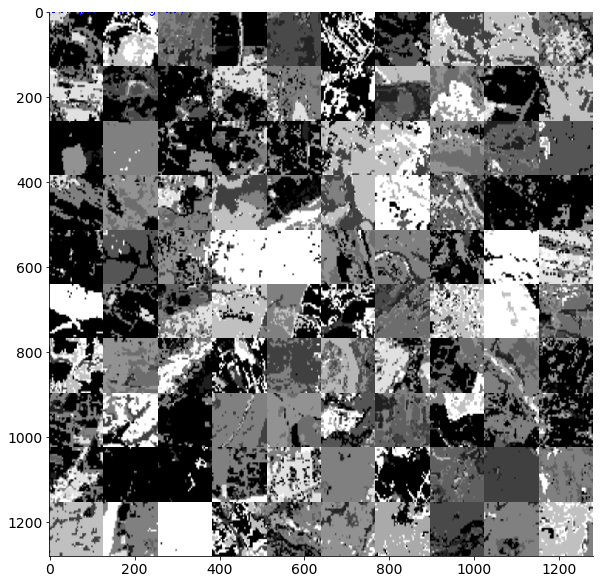

In [6]:
# Sample (quick look whole dataset)
plt_style()
_ = CPutils.montage_data(dataset=FULL_DATA_PATH,
                             imgShape=(128,128),
                             sample=100,
                             montageShape=(10,10), 
                             show=False)
plt.imshow(_)

# Images, channels, and dimensions

In [7]:
# Get images and labels
imgPaths = list(CPutils.paths.list_images(FULL_DATA_PATH))
resized_images = np.array([cv2.resize(cv2.imread(image,0), (38,31)) for image in imgPaths])
labels = np.array([image.split(os.path.sep)[-1].split('_')[0] for image in imgPaths]).astype(np.int)

In [8]:
# Get images and labels
imgPaths = list(CPutils.paths.list_images(FULL_DATA_PATH))
original_images = np.array([cv2.imread(image,0) for image in imgPaths])
labels = np.array([image.split(os.path.sep)[-1].split('_')[0] for image in imgPaths]).astype(np.int)

In [9]:
# Get images and labels
imgPaths = list(CPutils.paths.list_images(FULL_DATA_PATH))
original_images_3channel = np.array([cv2.imread(image) for image in imgPaths])
labels = np.array([image.split(os.path.sep)[-1].split('_')[0] for image in imgPaths]).astype(np.int)

In [10]:
# Dimensions
XDIMS = []
YDIMS = []
for image in original_images:
    x, y = image.shape
    XDIMS.append(x)
    YDIMS.append(y)
XDIMS = np.array(XDIMS)
YDIMS = np.array(YDIMS)

In [11]:
print("mean:",np.mean(XDIMS), 
      "\nmax:", np.max(XDIMS),
      "\nmin:", np.min(XDIMS),
      "\nstd:", np.std(XDIMS))

mean: 31.63109391888048 
max: 32 
min: 31 
std: 0.48250842939015837


In [12]:
print("mean:",np.mean(YDIMS), 
      "\nmax:", np.max(YDIMS),
      "\nmin:", np.min(YDIMS),
      "\nstd:", np.std(YDIMS))

mean: 38.64884236873542 
max: 43 
min: 36 
std: 1.4046339070699505


# Compare original and resized quality

## Original

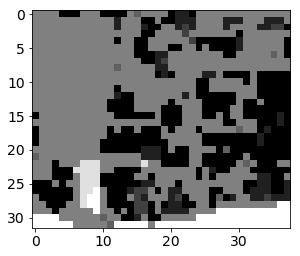

In [13]:
plt.imshow(original_images[1], cmap='gray')

## Resized

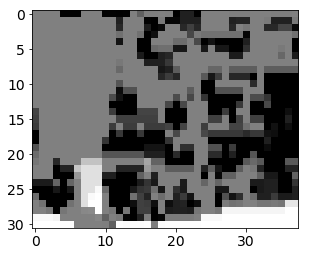

In [14]:
plt.imshow(resized_images[1], cmap='gray')

# Pad and Crop images
- To mean dimensions
- To min dimensions
- To max dimensions

In [15]:
# Crop images to mean dimensions
mean_cropped_images = [image[:int(np.mean(XDIMS)), :int(np.mean(YDIMS))] for image in original_images]

In [16]:
# Crop images to min dimensions
min_cropped_images = [image[:int(np.min(XDIMS)), :int(np.min(YDIMS))] for image in original_images]

In [17]:
# Pad max dimension
verbose = False
MAX_X = int(np.max(XDIMS))
MAX_Y = int(np.max(YDIMS))
counter = 0
max_padded_images = []

for idx, image in enumerate(original_images):
    x,y = image.shape
    dx = MAX_X - x
    dy = MAX_Y - y
    
    # Pad needed
    if dx != 0 or dy != 0 :
        top, bottom, left, right = 0,0,0,0
        if verbose:
            print("idx:", idx, image.shape)
            print("\tx,y:", x,y)
            print("\tdx,dy:", dx,dy)
        counter += 1

        if dx % 2 == 0 and dx != 0:
            top, bottom = int(dx / 2), int(dx / 2)
        elif dx % 2 != 0 and dx != 0:
            top, bottom = int(dx // 2 + 1), int(dx // 2)

        if dy % 2 == 0 and dy != 0:
            left, right = int(dy / 2), int(dy / 2)
        elif dy % 2 != 0 and dy != 0:
            left, right = int(dy // 2 + 1), int(dy // 2)

        if verbose:
            print("\ttop,bottom,left,right:", top, bottom, left, right)
        padded_image = cv2.copyMakeBorder(image.copy(),top, bottom, left, right, 
                                          cv2.BORDER_CONSTANT,value=[0,0,0])
        max_padded_images.append(padded_image)
        
    # No pad is needed
    else:
        max_padded_images.append(image)

max_padded_images = np.array(max_padded_images)
print("MAX_X:", MAX_X)        
print("MAX_Y:", MAX_Y)        
print("Total padded:", counter)
print("NEW IMAGE ARRAY SHAPE:", max_padded_images.shape)

MAX_X: 32
MAX_Y: 43
Total padded: 17505
NEW IMAGE ARRAY SHAPE: (17579, 32, 43)


In [18]:
# Pad mean dimensions
verbose = False
MAX_X = int(np.mean(XDIMS))
MAX_Y = int(np.mean(YDIMS))
counter = 0
mean_cropped_padded_images = []

for idx, image in enumerate(mean_cropped_images):
    x,y = image.shape
    dx = MAX_X - x
    dy = MAX_Y - y
    
    # Pad needed
    if dx != 0 or dy != 0 :
        top, bottom, left, right = 0,0,0,0
        if verbose:
            print("idx:", idx, image.shape)
            print("\tx,y:", x,y)
            print("\tdx,dy:", dx,dy)
        counter += 1

        if dx % 2 == 0 and dx != 0:
            top, bottom = int(dx / 2), int(dx / 2)
        elif dx % 2 != 0 and dx != 0:
            top, bottom = int(dx // 2 + 1), int(dx // 2)

        if dy % 2 == 0 and dy != 0:
            left, right = int(dy / 2), int(dy / 2)
        elif dy % 2 != 0 and dy != 0:
            left, right = int(dy // 2 + 1), int(dy // 2)

        if verbose:
            print("\ttop,bottom,left,right:", top, bottom, left, right)
        padded_image = cv2.copyMakeBorder(image.copy(),top, bottom, left, right, 
                                          cv2.BORDER_CONSTANT,value=[0,0,0])
        mean_cropped_padded_images.append(padded_image)
        
    # No pad is needed
    else:
        mean_cropped_padded_images.append(image)

mean_cropped_padded_images = np.array(mean_cropped_padded_images)
print("MAX_X:", MAX_X)        
print("MAX_Y:", MAX_Y)        
print("Total padded:", counter)
print("NEW IMAGE ARRAY SHAPE:", mean_cropped_padded_images.shape)

MAX_X: 31
MAX_Y: 38
Total padded: 3793
NEW IMAGE ARRAY SHAPE: (17579, 31, 38)


In [19]:
# Min cropped images
min_cropped_images = np.array(min_cropped_images)
print("MAX_X:", min_cropped_images[0].shape[0])        
print("MAX_Y:", min_cropped_images[0].shape[1])        
print("NEW IMAGE ARRAY SHAPE:", min_cropped_images.shape)

MAX_X: 31
MAX_Y: 36
NEW IMAGE ARRAY SHAPE: (17579, 31, 36)


## Mean crop

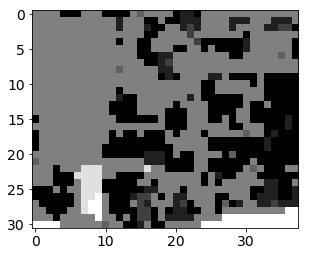

In [20]:
plt.imshow(mean_cropped_padded_images[1], cmap='gray')

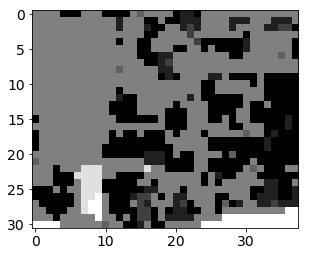

In [21]:
plt.imshow(mean_cropped_images[1], cmap='gray')

## Min crop

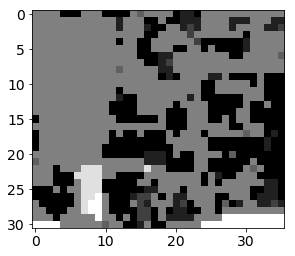

In [22]:
plt.imshow(min_cropped_images[1], cmap='gray')

## Max pad

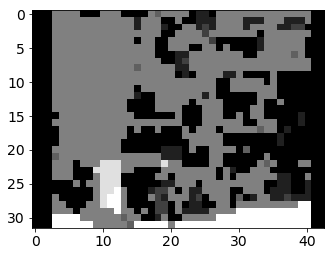

In [23]:
plt.imshow(max_padded_images[1], cmap='gray')

## Save processed sets

In [151]:
BASE = '../data/padded_cropped/gray_scale'
# cdump(mean_cropped_padded_images, os.path.join(BASE, 'mean_dimensions.lzma'), compression='lzma')
# cdump(min_cropped_images, os.path.join(BASE, 'min_dimensions.lzma'), compression='lzma')
# cdump(max_padded_images, os.path.join(BASE, 'max_dimensions.lzma'), compression='lzma')
# cdump(original_images, os.path.join(BASE, 'original_dimensions.lzma'), compression='lzma')
# cdump(resized_images, os.path.join(BASE, 'resized_dimensions.lzma'), compression='lzma')
# cdump(labels, os.path.join(BASE, 'labels.lzma'), compression='lzma')

# Train and test split

In [24]:
# Train/test split (25%)
seed = 42
Xtrain, Xtest, ytrain, ytest = train_test_split(mean_cropped_padded_images, 
                                                labels, 
                                                test_size=0.25, 
                                                random_state=seed)

In [25]:
print("Dims X (train and test):", Xtrain.shape, Xtest.shape)
print("Dims Y (train and test):", ytrain.shape, ytest.shape)

Dims X (train and test): (13184, 31, 38) (4395, 31, 38)
Dims Y (train and test): (13184,) (4395,)


In [27]:
np.expand_dims(Xtrain, axis=-1).shape

(13184, 31, 38, 1)

# Smote and images

In [154]:
# Importation
from smrt.balance import smote_balance

# Generate synthetic images from SMOTE
X_smote, y_smote = smote_balance(Xtrain.reshape(13184, 31 * 38), 
                                 ytrain,
                                 n_jobs=-1,
                                 random_state=seed,
                                 n_neighbors=25, 
                                 shuffle=False,
                                 balance_ratio=1.0)

In [ ]:
print(X_smote.shape, Counter(y_smote))

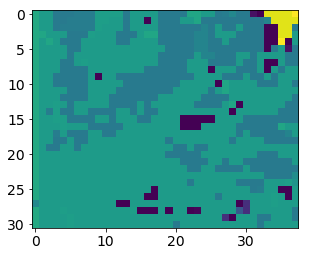

In [163]:
X_smote_images = X_smote.reshape((X_smote.shape[0], 31, 38))
plt.imshow(X_smote_images[-32])

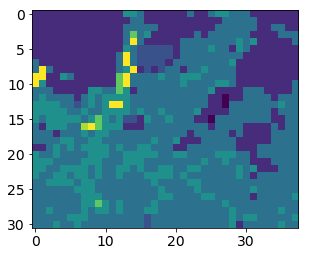

In [144]:
plt.imshow(Xtrain[-100])

In [164]:
from collections import Counter
Counter(y_smote)

Counter({0: 10541, 1: 10541})

In [165]:
# Save
cdump((X_smote_images, y_smote), os.path.join(BASE, 'Smote_train.lzma'), compression='lzma')
cdump((Xtest, ytest), os.path.join(BASE, 'Smote_test.lzma'), compression='lzma')